## Trec Spam Dataset

Here we explore the Trec Spam Dataset: https://plg.uwaterloo.ca/~gvcormac/treccorpus07/

In particular, we look to see if classification accuracy degrades over time, making the data suitable for our work on detecting confounding shift.

There does appear to be considerable variation in accuracy over time, though further analysis is needed to determine if there is any confounding shift happening.

This notebook assumes it is in the root of the `trec07p` folder and will access `data/*` and `full/index`.

In [75]:
from collections import Counter
import datetime
import email
from email import policy
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, roc_auc_score
import time

In [171]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import adaptive_confound.utils as acu
import adaptive_confound.topic_model as actm
from tqdm import tqdm_notebook
import seaborn as sns
sns.set('paper',
        'whitegrid',
        font_scale=1.25,
        palette='muted',#'colorblind',
        color_codes=True)

/home/virgile/.conda/envs/py36/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/virgile/.conda/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [ ]:
def yield_data(max_size=50000, prefix=""):
    """
    Ignoring hard to parse messages for now (utf8 issues...)
    """
    plcy = policy.EmailPolicy(utf8=False)
    parser = email.parser.Parser(policy=plcy)
    ct = 0
    for fname in glob.glob('{}data/*'.format(prefix)):
        try:
            msg = parser.parse(open(fname))
            body = msg2string(msg)
            body = body.decode('utf-8', 'ignore')
            date = s2date(msg['date'])
            ct += 1
            yield fname, date, body
            if ct % 1000 == 0:
                print(ct)
            if ct >= max_size:
                break
        except Exception as e:
            pass # silently fail!
            #print(e)        
            
def s2date(s):
    # date to timestamp
    return time.mktime(datetime.datetime.strptime(s[5:16], "%d %b %Y").timetuple())
    
def msg2string(b):
    """
    extract text of message
    """
    if b.is_multipart():
        for part in b.walk():
            ctype = part.get_content_type()
            cdispo = str(part.get('Content-Disposition'))

            # skip any text/plain (txt) attachments
            if ctype == 'text/plain' and 'attachment' not in cdispo:
                body = part.get_payload(decode=True)  # decode
                break
    # not multipart - i.e. plain text, no attachments, keeping fingers crossed
    else:
        body = b.get_payload(decode=True)
    return body

def get_labels(fnames, prefix=""):
    fname2label = {}
    for l in open('{}full/index'.format(prefix)):
        label, fname = l.split()
        label = 1 if label=='spam' else 0
        fname = fname[3:]
        fname2label[fname] = label
    return np.array([fname2label[f.replace(prefix, "")] for f in fnames])

fnames = []
dates = []
prefix = "/data/virgile/trec07p/"
vec = TfidfVectorizer(min_df=10)
X = vec.fit_transform(d[2] for d in yield_data(prefix=prefix) if not fnames.append(d[0]) and not dates.append(d[1]))
y = get_labels(fnames, prefix=prefix)
print(Counter(y))
X

In [21]:
# train on first N and test on remaining, seeing how performance degrades by time
train_size = 2000
# sort by date
time_idx = np.argsort(dates)
# train/test
clf = LogisticRegression(class_weight='balanced')
train_idx = time_idx[:train_size]
test_idx = time_idx[train_size:]
clf.fit(X[train_idx], y[train_idx])
preds = clf.predict(X[test_idx])
probas = clf.predict_proba(X[test_idx])
print('f1=', f1_score(preds, y[test_idx]))


f1= 0.9646016208110796


In [70]:
features = np.array(vec.get_feature_names())

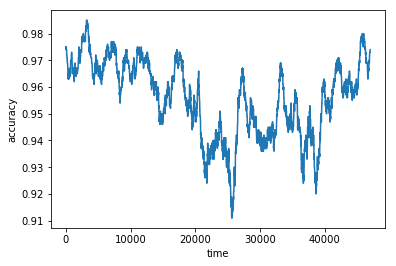

In [22]:
# plot moving average of F1
def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / float(N)

plt.figure()
plt.plot(running_mean((preds == y[test_idx]), 1000))
plt.xlabel('time')
plt.ylabel('accuracy')
plt.show()

In [29]:
# train over time and print top terms.
# looks like new terms get introduced. not sure if terms change sign.
def print_top_terms(clf, vec, n=10):
    for i in np.argsort(clf.coef_[0])[::-1][:n]:
        print('%20s\t%.1f' % (vec.get_feature_names()[i], clf.coef_[0][i]))

#print_top_terms(clf, vec)
step = 1000
for x in range(len(y))[::step]:
    idx = time_idx[x:x+step]
    clf.fit(X[idx], y[idx])
    print_top_terms(clf, vec, n=10)
    print('\n\n')

                 you	1.4
               price	1.1
                your	1.1
                 our	0.9
                more	0.9
              target	0.9
                 men	0.8
                  he	0.8
                 per	0.7
                  we	0.7



                cdyv	1.7
              target	1.4
                 you	1.3
               price	1.3
                your	1.3
                 and	1.1
                  ed	1.0
              viagra	1.0
                 089	0.9
                 was	0.9



                your	1.5
                  83	1.5
                 you	1.4
              viagra	1.4
              target	1.3
                 our	1.1
                 and	1.1
                  br	1.0
              online	0.9
                  ed	0.9



                 you	1.6
              viagra	1.4
                your	1.3
              target	1.2
                 and	1.1
               price	1.1
                said	1.0
                life	0.9
              broker	0.8
                

## Detect if confounding shift happens in this dataset:

- terms change sign between training and testing

In [99]:
step = 1000

In [100]:
windows = [time_idx[x : x+step] for x in range(len(y))[::step]]

In [101]:
window_coefs = np.vstack([clf.fit(X[idx], y[idx]).coef_[0] for idx in tqdm_notebook(windows)])

In [113]:
sign_window_coefs = np.sign(window_coefs)
sign_changed_count = []
for i in range(sign_window_coefs.shape[0] - 1):
    sign_changed_count.append(sign_window_coefs[i] - sign_window_coefs[i:])
sign_changed_count = np.abs( np.vstack(sign_changed_count) )
sign_changed_count = np.sum( sign_changed_count == 2, axis=0 )

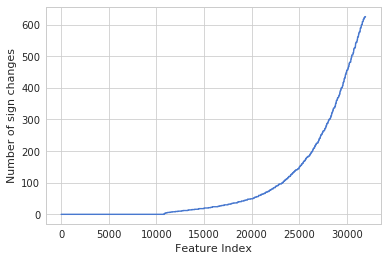

In [136]:
fig, ax = plt.subplots()
ax.plot(range(len(sign_changed_count)), np.sort(sign_changed_count))
ax.set_xlabel("Feature Index")
ax.set_ylabel("Number of sign changes")

In [170]:
most_changed_idx = sign_changed_count.argsort()[::-1]
k = 20
pd.options.display.max_rows = 200
pd.DataFrame(
    np.array([ features[most_changed_idx][:k], sign_changed_count[most_changed_idx][:k] ]).T,
    columns=[ "Feature", "Number of sign change" ]
)


,Feature,Number of sign change
0,direction,625
1,operation,625
2,warn,625
3,efficient,625
4,number,625
5,smith,625
6,application,625
7,computers,625
8,large,625
9,apple,625


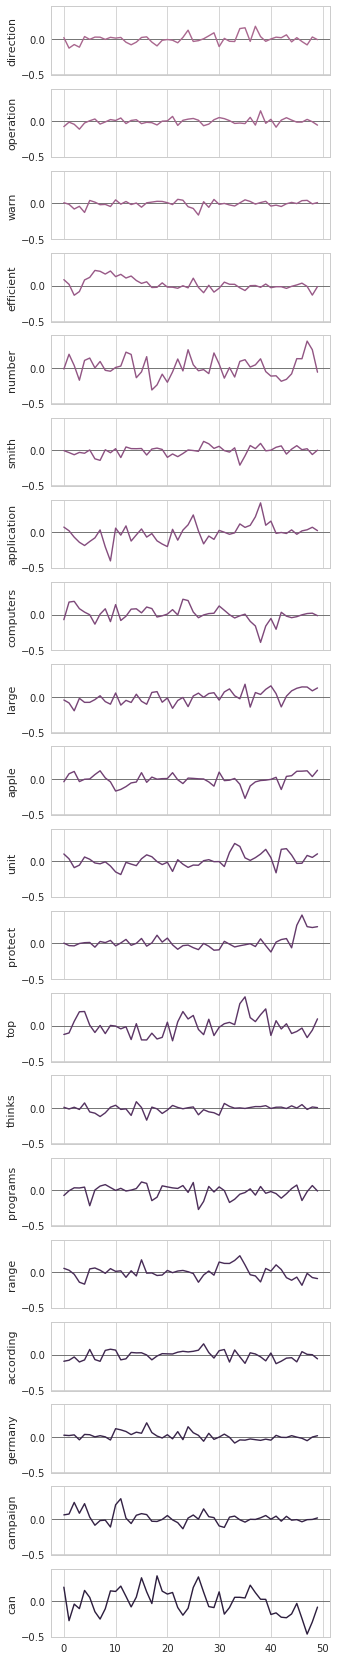

In [169]:
k = 20
k_most_changed = most_changed_idx[:k]
fig, ax = plt.subplots(nrows=k, figsize=(5,int(1.5 * k)), sharex=True, sharey=True)

xdata = range(window_coefs.shape[0])
for i, (line, label, color) in enumerate(zip(
    window_coefs[:, k_most_changed].T,
    features[k_most_changed],
    sns.palettes.cubehelix_palette(n_colors=k, light=.5)
)):
    ax[i].axhline(color='k', lw=.5)
    ax[i].plot(xdata, line, color=color)
    ax[i].set_ylabel(label)

- Topic sign changes from on data split to another

In [180]:
from sklearn.decomposition import LatentDirichletAllocation

In [ ]:
n_topics = 50
lda = LatentDirichletAllocation(n_components=n_topics, verbose=2)
X_lda = lda.fit_transform(X)

In [251]:
window_coefs_lda = np.vstack([clf.fit(X_lda[idx], y[idx]).coef_[0] for idx in tqdm_notebook(windows)])

In [252]:
sign_window_coefs_lda = np.sign(window_coefs_lda)
sign_changed_count_lda = []
for i in range(sign_window_coefs_lda.shape[0] - 1):
    sign_changed_count_lda.append(sign_window_coefs_lda[i] - sign_window_coefs_lda[i:])
sign_changed_count_lda = np.abs( np.vstack(sign_changed_count_lda) )
sign_changed_count_lda = np.sum( sign_changed_count_lda == 2, axis=0 )

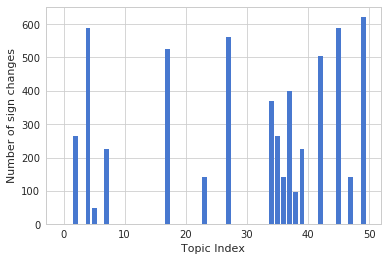

In [253]:
fig, ax = plt.subplots()
ax.bar(range(len(sign_changed_count_lda)), sign_changed_count_lda)
ax.set_xlabel("Topic Index")
ax.set_ylabel("Number of sign changes")

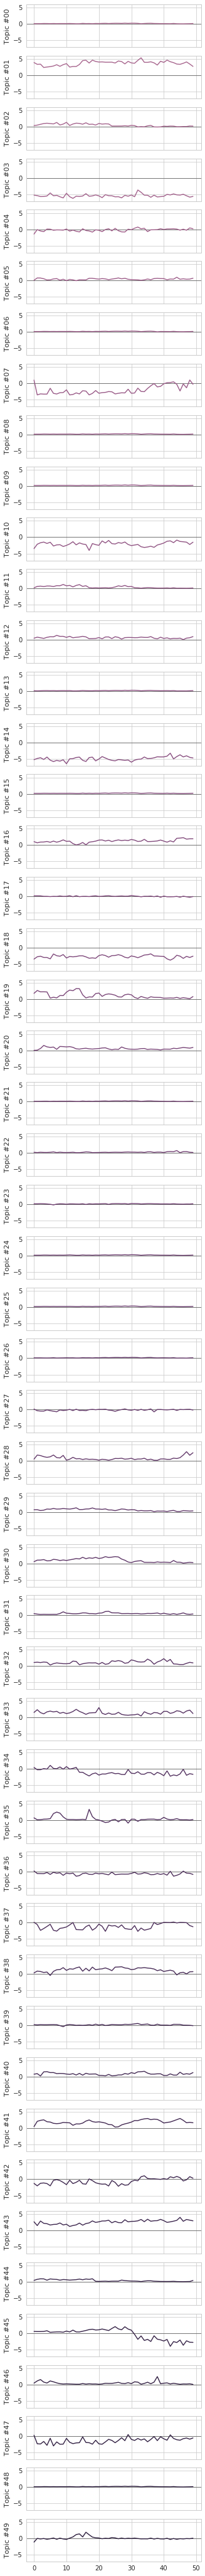

In [254]:
fig, ax = plt.subplots(nrows=n_topics, figsize=(5,int(1.5 * n_topics)), sharex=True, sharey=True)

xdata = range(window_coefs_lda.shape[0])
for i, (line, label, color) in enumerate(zip(
    window_coefs_lda.T,
    ["Topic #{:02d}".format(j) for j in range(n_topics)],
    sns.palettes.cubehelix_palette(n_colors=n_topics, light=.5)
)):
    ax[i].axhline(color='k', lw=.5)
    ax[i].plot(xdata, line, color=color)
    ax[i].set_ylabel(label)

In [279]:
spamham.z = (X_lda.argmax(axis=1) == 7).astype(int)

In [280]:
windows_dataset = [acu.Dataset(X=spamham.X[idx], y=spamham.y[idx], z=spamham.z[idx]) for idx in tqdm_notebook(windows)]

In [281]:
n_datasets = len(windows_dataset)
f1_matrix = np.zeros((n_datasets, n_datasets))
for i, d1 in enumerate(tqdm_notebook(windows_dataset)):
    clf.fit(d1.X, d1.y)
    for j, d2 in enumerate(windows_dataset[i+1:]):
        y_pred = clf.predict(d2.X)
        f1_matrix[i,i+1+j] = f1_score(d2.y, y_pred)

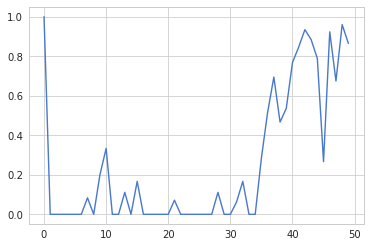

In [282]:
plt.plot([w.get_bias() for w in windows_dataset])